In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 46.4 MB/s 
     |████████████████████████████████| 596 kB 37.7 MB/s 
     |████████████████████████████████| 61 kB 519 kB/s 
     |████████████████████████████████| 895 kB 61.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# required libraries
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')
# load dataset 

In [ ]:
# import dataset from drive
import os
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:

df_1429 = pd.read_csv('/content/gdrive/My Drive/Stat 198 - final project/archive/1429_1.csv')
data3 = pd.read_csv('/content/gdrive/My Drive/Stat 198 - final project/archive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')
data2 = pd.read_csv('/content/gdrive/My Drive/Stat 198 - final project/archive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [ ]:
# iterating the columns
for col in df_1429.columns:
    print(col)

id
name
asins
brand
categories
keys
manufacturer
reviews.date
reviews.dateAdded
reviews.dateSeen
reviews.didPurchase
reviews.doRecommend
reviews.id
reviews.numHelpful
reviews.rating
reviews.sourceURLs
reviews.text
reviews.title
reviews.userCity
reviews.userProvince
reviews.username


In [ ]:
df_1429.shape

(34660, 21)

In [ ]:
data = df_1429[["reviews.text","reviews.rating", "reviews.date"]]
data.head()

,reviews.text,reviews.rating,reviews.date
0,This product so far has not disappointed. My c...,5.0,2017-01-13T00:00:00.000Z
1,great for beginner or experienced person. Boug...,5.0,2017-01-13T00:00:00.000Z
2,Inexpensive tablet for him to use and learn on...,5.0,2017-01-13T00:00:00.000Z
3,I've had my Fire HD 8 two weeks now and I love...,4.0,2017-01-13T00:00:00.000Z
4,I bought this for my grand daughter when she c...,5.0,2017-01-12T00:00:00.000Z


In [ ]:
# drop missing values
data.dropna(inplace=True)
data.isnull().sum()

reviews.text      0
reviews.rating    0
reviews.date      0
dtype: int64

## Exploratory Data Analysis

In [ ]:
# explore some of the reviews
import random

n_samples = 5

for _ in range(n_samples):
    i = random.choice(range(data.shape[0]))
    print(f"REVIEW TEXT:\n{data['reviews.text'][i]} \n\nRATE:\n{data['reviews.rating'][i]}")
    print('\n', 90*"-", '\n')

REVIEW TEXT:
I have owned several Kindles and this is the best one yet 

RATE:
5.0

 ------------------------------------------------------------------------------------------ 

REVIEW TEXT:
Alexa is a wonderful companion and will never fail to impress your friends. Want to know the weather in Texarkana or Timbuktu? No problem... just ask her. Or how far is it from here to Istanbul or Indianapolis? No sweat. Wanna hear some music? Just ask her to play The Eagles or Jackson Brown, Iron Maiden or Frank Sinatra. It's easy. And that's just scratching the surface. 

RATE:
5.0

 ------------------------------------------------------------------------------------------ 

REVIEW TEXT:
For the price of this tablet its well worth the money very durable and works well 

RATE:
4.0

 ------------------------------------------------------------------------------------------ 

REVIEW TEXT:
Bought this for my wife who loves books. She was always agents ebooks but now she can't be without it. 

RATE:
5

In [ ]:
# distribution of rating
data['reviews.rating'].value_counts().sort_index(ascending=False)

5.0    23755
4.0     8531
3.0     1499
2.0      402
1.0      410
Name: reviews.rating, dtype: int64

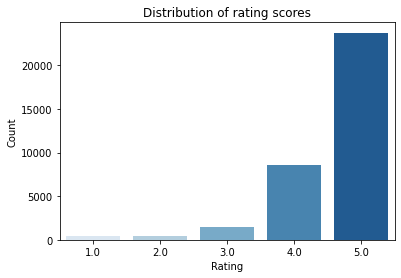

In [ ]:
# distribution of rating
sns.countplot(data['reviews.rating'], palette='Blues')

plt.title('Distribution of rating scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
# load the other data
data2 = data2[['reviews.text', 'reviews.rating']]
# use only data of rating lower than or equal to 3
data2 = data2[data2["reviews.rating"] <= 3].reset_index(drop=True) # reset index after filtering rows

data3 = data3[['reviews.text', 'reviews.rating']]
# use only data of rating lower than or equal to 3
data3 = data3[data3["reviews.rating"] <= 3].reset_index(drop=True) # reset index after filtering rows

In [ ]:
# distribution of rating
data2['reviews.rating'].value_counts().sort_index(ascending=False)

3    1206
2     616
1     965
Name: reviews.rating, dtype: int64

In [ ]:
# distribution of rating
data3['reviews.rating'].value_counts().sort_index(ascending=False)

3    197
2     54
1     63
Name: reviews.rating, dtype: int64

In [ ]:
# concatenation
data = pd.concat([data, data2, data3])

# assert data.shape[0] == data.shape[0] + data2.shape[0] + data3.shape[0]
data.head()

,reviews.text,reviews.rating,reviews.date
0,This product so far has not disappointed. My c...,5.0,2017-01-13T00:00:00.000Z
1,great for beginner or experienced person. Boug...,5.0,2017-01-13T00:00:00.000Z
2,Inexpensive tablet for him to use and learn on...,5.0,2017-01-13T00:00:00.000Z
3,I've had my Fire HD 8 two weeks now and I love...,4.0,2017-01-13T00:00:00.000Z
4,I bought this for my grand daughter when she c...,5.0,2017-01-12T00:00:00.000Z


In [ ]:
# distribution of rating
data['reviews.rating'].value_counts().sort_index(ascending=False)

5.0    23755
4.0     8531
3.0     2902
2.0     1072
1.0     1438
Name: reviews.rating, dtype: int64

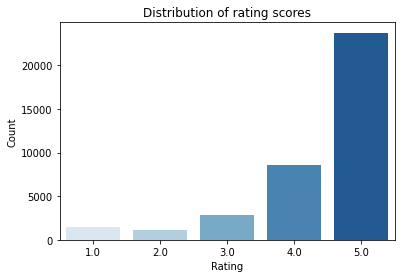

In [ ]:
# distribution of rating
sns.countplot(data['reviews.rating'], palette='Blues')

plt.title('Distribution of rating scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
# map ratings 1, 2, 3 to 0 (NEGATIVE) and 4, 5 to 1 (POSITIVE) 
sentiment_score = {1: 0,
                   2: 0,
                   3: 0,
                   4: 1,
                   5: 1}

sentiment = {0: 'NEGATIVE',
             1: 'POSITIVE'}


# mapping
data['sentiment_score'] = data['reviews.rating'].map(sentiment_score)
data['sentiment'] = data['sentiment_score'].map(sentiment)

data.head()

,reviews.text,reviews.rating,reviews.date,sentiment_score,sentiment
0,This product so far has not disappointed. My c...,5.0,2017-01-13T00:00:00.000Z,1,POSITIVE
1,great for beginner or experienced person. Boug...,5.0,2017-01-13T00:00:00.000Z,1,POSITIVE
2,Inexpensive tablet for him to use and learn on...,5.0,2017-01-13T00:00:00.000Z,1,POSITIVE
3,I've had my Fire HD 8 two weeks now and I love...,4.0,2017-01-13T00:00:00.000Z,1,POSITIVE
4,I bought this for my grand daughter when she c...,5.0,2017-01-12T00:00:00.000Z,1,POSITIVE


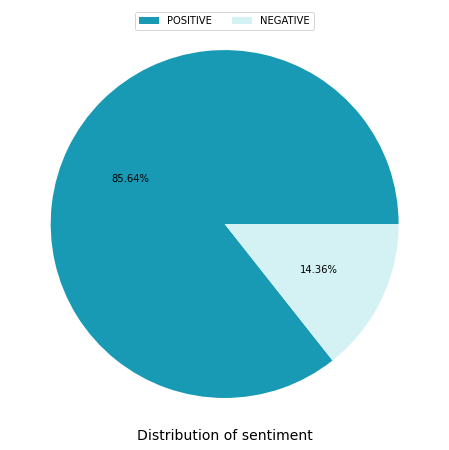

In [ ]:
# distribution of sentiment
plt.figure(figsize = (8, 8))

labels = ['POSITIVE', 'NEGATIVE']
colors = ['#189AB4', '#D4F1F4']
plt.pie(data['sentiment'].value_counts(), autopct='%0.2f%%',colors=colors)

plt.title('Distribution of sentiment', size=14, y=-0.01)
plt.legend(labels, ncol=2, loc=9)
plt.show()

In [ ]:
# get all used words 
all_words = pd.Series(' '.join(data['reviews.text']).split())

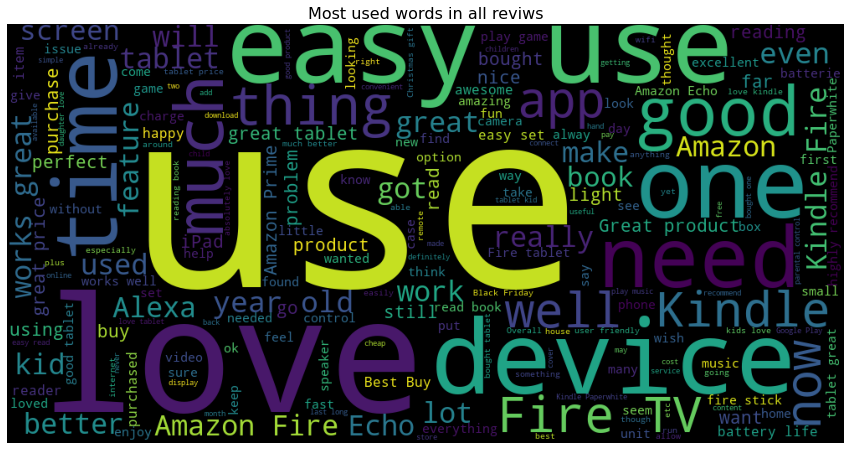

In [ ]:
# plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(all_words))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in all reviws", size=16)

plt.axis("off")
plt.show()


In [ ]:
# get words used negative reivews 
negativeWords = pd.Series(' '.join(data[data['sentiment']=='NEGATIVE']['reviews.text']).split())

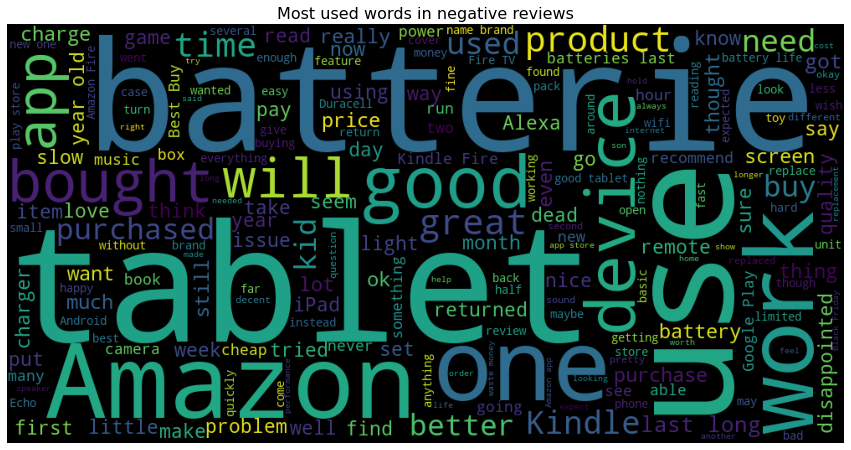

In [ ]:
# plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(negativeWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in negative reviews", size=16)

plt.axis("off")
plt.show()

## Feature Engineering

In [ ]:
 import nltk
 nltk.download('punkt')

def clean_text(text:str):
    """ Return cleaned text:
            - lowercase
            - remove whitespaces
            - remove HTML tags
            - replace digit with spaces
            - replace punctuations with spaces
            - remove extra spaces and tabs
        ------
        input: text (str)    
        output: cleaned text (str)
    """
    text = str(text)
    
    text = text.lower()
    text = text.strip()
    
    text = re.sub(' \d+', ' ', text)
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    
    text = text.strip()
    
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
clean_text(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'this is a message to be cleaned it may involve some things like adjacent spaces and tabs'

In [ ]:
def remove_stopwords(text:str):
    """ Remove stopwords from text:
        ------
        input: text (str)    
        output: cleaned text (str)
    """
    text = str(text)
    filtered_sentence = []

    # Stop word lists can be adjusted for your problem
    stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(w)
    text = " ".join(filtered_sentence)
    
    return text

In [ ]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
remove_stopwords(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'message be cleaned may involve some things like adjacent spaces tabs'

In [ ]:
def stemm_text(text:str):
    """ Stemm text:
    ------
    input: text (str)    
    output: Stemmed text (str)
    """
    text = str(text)
    # Initialize the stemmer
    snow = SnowballStemmer('english')

    stemmed_sentence = []
    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        # Stem the word/token
        stemmed_sentence.append(snow.stem(w))
    text = " ".join(stemmed_sentence)
    
    return text

In [ ]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
text = remove_stopwords(text)
stemm_text(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'messag be clean may involv some thing like adjac space tab'

In [ ]:
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def lemmatize(text:str):
    """ lemmatize text:
    ------
    input: text (str)    
    output: lemmatized text (str)
    """
    text = str(text)
    
    # Initialize the lemmatizer
    wl = WordNetLemmatizer()

    lemmatized_sentence = []

    # Tokenize the sentence
    words = word_tokenize(text)
    # Get position tags
    word_pos_tags = nltk.pos_tag(words)
    # Map the position tag and lemmatize the word/token
    for idx, tag in enumerate(word_pos_tags):
        lemmatized_sentence.append(wl.lemmatize(tag[0], get_wordnet_pos(tag[1])))

    lemmatized_text = " ".join(lemmatized_sentence)
    
    return lemmatized_text

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
text = remove_stopwords(text)
# text = stemm_text(text)
lemmatize(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'message be clean may involve some thing like adjacent space tabs'

In [ ]:
# clean text
data['text'] = data['reviews.text'].apply(clean_text)
# remove stopwords
data['text'] = data['text'].apply(remove_stopwords)
# lemmatize
data['text'] = data['text'].apply(lemmatize)

In [ ]:
# check some processed reviews
import random

i = random.choice(range(len(data)))

print(f"Original review: \n{data['reviews.text'].iloc[i]}\n")
print(f"Processed review: \n{data['text'].iloc[i]}")      

Original review: 
I bought this tablet for my 4 year old daughter. Too many advertisements. I would rather pay more and not have a single ad.

Processed review: 
i buy tablet for my year old daughter too many advertisement i would rather pay more not have single ad


In [ ]:
# export cleaned data to csv
data.to_csv('cleaned_data.csv', index=False)

In [ ]:
data = pd.read_csv('cleaned_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37698 entries, 0 to 37697
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviews.text     37698 non-null  object 
 1   reviews.rating   37698 non-null  float64
 2   reviews.date     34597 non-null  object 
 3   sentiment_score  37698 non-null  int64  
 4   sentiment        37698 non-null  object 
 5   text             37697 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.7+ MB


In [ ]:
data[data['text'].isnull()]

,reviews.text,reviews.rating,reviews.date,sentiment_score,sentiment,text
9680,.................................................,5.0,2016-09-09T00:00:00.000Z,1,POSITIVE,NaN


In [ ]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34596 entries, 0 to 34596
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviews.text     34596 non-null  object 
 1   reviews.rating   34596 non-null  float64
 2   reviews.date     34596 non-null  object 
 3   sentiment_score  34596 non-null  int64  
 4   sentiment        34596 non-null  object 
 5   text             34596 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.8+ MB


# Modeling

In [ ]:
vectorizer = TfidfVectorizer(max_features=700)
vectorizer.fit(data['text'])
features = vectorizer.transform(data['text'])

features.toarray()

array([[0.        , 0.31539065, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
tf_idf = pd.DataFrame(features.toarray(), columns=vectorizer.get_feature_names())
# tf_idf.drop('50', axis=1, inplace=True)
tf_idf.head()

,50,ability,able,about,absolutely,access,account,actually,ad,add,addition,additional,adjust,adult,affordable,after,again,age,ago,alarm,alexa,all,allow,almost,along,already,also,although,always,amaze,amazing,amazon,amount,android,another,answer,any,anyone,anything,anywhere,...,watch,way,we,weather,web,week,weight,well,what,when,where,which,while,white,who,whole,why,wife,wifi,will,win,wireless,wish,with,without,wonderful,word,work,worry,worth,would,wouldn,wrong,year,yet,you,young,your,youtube,yr
0,0.0,0.315391,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.213954,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.141995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.311219,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.146504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.113435,0.0,0.0,0.128268,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.083975,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.147473,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.106779,0.0,0.093909,0.0,0.0,0.143359,0.0,0.088246,0.000000,0.000000,0.147639,0.115483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075194,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.117880,0.0,0.0,0.0,0.0,0.0,0.154985,0.0,0.0,0.0,0.0,0.0,0.268404,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.091424,0.0,0.0,0.0,0.000000,0.071271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.180966,0.000000,0.106131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095013,0.0,0.0,0.0,0.059916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069105,0.0,0.0,0.0,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf, data['sentiment_score'], test_size=0.2, random_state=42)

print (f'Train set shape\t:{X_train.shape}\nTest set shape\t:{X_test.shape}')

Train set shape	:(27676, 700)
Test set shape	:(6920, 700)


In [ ]:
yy = pd.DataFrame(y_train)
train_data = pd.concat([X_train, yy],axis=1)
train_data.head()

,50,ability,able,about,absolutely,access,account,actually,ad,add,addition,additional,adjust,adult,affordable,after,again,age,ago,alarm,alexa,all,allow,almost,along,already,also,although,always,amaze,amazing,amazon,amount,android,another,answer,any,anyone,anything,anywhere,...,way,we,weather,web,week,weight,well,what,when,where,which,while,white,who,whole,why,wife,wifi,will,win,wireless,wish,with,without,wonderful,word,work,worry,worth,would,wouldn,wrong,year,yet,you,young,your,youtube,yr,sentiment_score
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.311219,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146504,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.113435,0.0,0.0,0.128268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.083975,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.147473,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.093909,0.0,0.0,0.143359,0.0,0.088246,0.0,0.0,0.147639,0.115483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.075194,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270017,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.132503,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.153481,0.0,0.0,0.168667,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.18067,0.0,0.0,0.0,0.0,0.0,...,0.170066,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183772,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0


In [ ]:
train_data['sentiment_score'].value_counts()

1.0    25845
0.0     1831
Name: sentiment_score, dtype: int64

In [ ]:
target_count = train_data['sentiment_score'].value_counts()
negative_class = train_data[train_data['sentiment_score'] == 0]
positive_class = train_data[train_data['sentiment_score'] == 1]

negative_over = negative_class.sample(target_count[1], replace=True)

df_train_over = pd.concat([positive_class, negative_over], axis=0)
df_train_over = shuffle(df_train_over)
df_train_over.head()

,50,ability,able,about,absolutely,access,account,actually,ad,add,addition,additional,adjust,adult,affordable,after,again,age,ago,alarm,alexa,all,allow,almost,along,already,also,although,always,amaze,amazing,amazon,amount,android,another,answer,any,anyone,anything,anywhere,...,way,we,weather,web,week,weight,well,what,when,where,which,while,white,who,whole,why,wife,wifi,will,win,wireless,wish,with,without,wonderful,word,work,worry,worth,would,wouldn,wrong,year,yet,you,young,your,youtube,yr,sentiment_score
11778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
16080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.301669,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.288303,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.317395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096203,0.0,0.0,0.0,...,0.0,0.478234,0.0,0.0,0.0,0.0,0.0,0.0,0.083565,0.0,0.0,0.0,0.0,0.0,0.0,0.131832,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
df_train_over.dropna(inplace=True)

In [ ]:
df_train_over['sentiment_score'].value_counts()

0.0    22354
1.0    22146
Name: sentiment_score, dtype: int64

In [ ]:
X_train = df_train_over.iloc[:,:-1]
y_train = df_train_over['sentiment_score']

In [ ]:
def modeling(Model, Xtrain = X_train, Xtest = X_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    print(classification_report(y_test, y_pred))
    print ('AUC ',roc_auc_score(y_test, y_pred))
    #cm = confusion_matrix(y_test, y_pred)
    confusion_matrix = pd.crosstab(index=y_test, columns=np.round(y_pred), rownames=['Actual'], colnames=['Predictions']).astype(int)
    plt.figure(figsize = (8,8))

    '''
    cmapGR = LinearSegmentedColormap.from_list(
        name='test', 
        colors=['red','green']
    )
    '''
    sns.heatmap(confusion_matrix, annot=True,annot_kws={"fontsize":12}, fmt='.2f', cmap='Blues').set_title('Confusion Matrix') 

              precision    recall  f1-score   support

           0       0.17      0.79      0.28       480
           1       0.98      0.71      0.83      6440

    accuracy                           0.72      6920
   macro avg       0.58      0.75      0.55      6920
weighted avg       0.92      0.72      0.79      6920

AUC  0.7537072981366459


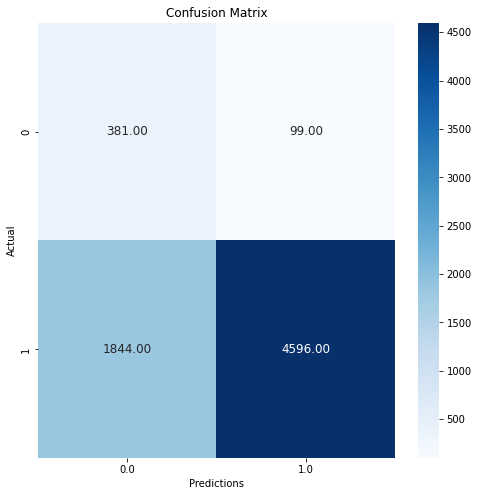

In [ ]:
modeling(MultinomialNB())

              precision    recall  f1-score   support

           0       0.18      0.68      0.29       480
           1       0.97      0.78      0.86      6440

    accuracy                           0.77      6920
   macro avg       0.58      0.73      0.58      6920
weighted avg       0.92      0.77      0.82      6920

AUC  0.7260869565217392


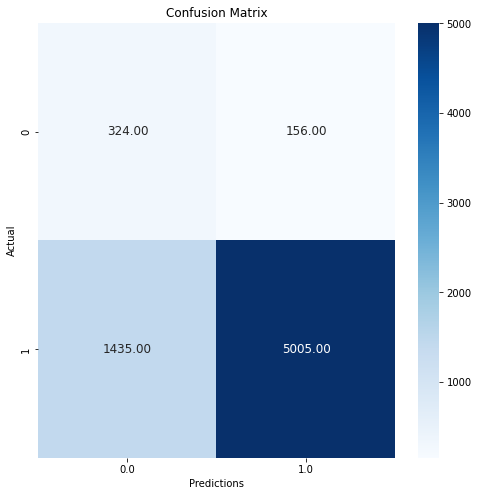

In [ ]:
modeling(XGBClassifier());

In [ ]:
# Build sentiment analysis pipeline
sentiment_analyzer = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
# test
sentiment_analyzer(['Good product', 'Bad custemer service'])

[{'label': 'POSITIVE', 'score': 0.9998588562011719},
 {'label': 'NEGATIVE', 'score': 0.999789297580719}]

In [ ]:
# wrapper function for sentiment analysis
# Input s is expected to be a string of review
# Outputs 1 if positive 0 if negative
def sentimentWrapper(s):
    try:
      label = sentiment_analyzer(s)[0]['label']=='POSITIVE' 
    except:
      label = 'NEGATIVE'
    return 1 if label else 0

sentimentWrapper("I hate this product")


0

In [ ]:
dataNew = data.drop(columns=['sentiment_score', 'sentiment', 'reviews.rating', 'reviews.text'])
dataNew['sentimentScore'] = dataNew['text'].apply(sentimentWrapper)
#dataNew['sentimentScore'] = data[['text']].apply(sentimentWrapper)

In [ ]:
# Please do not run this line. The result file is materialized in the drive
#dataNew.to_csv('/content/gdrive/My Drive/Stat 198 - final project/archive/cleaned_data_with_sentiment_prediction.csv', index=False)

In [ ]:
dataNew = pd.read_csv('/content/gdrive/My Drive/Stat 198 - final project/archive/cleaned_data_with_sentiment_prediction.csv')


In [ ]:
import re

def getMonth(s):
    # returns the month as an integer
    return int(re.findall('.*\-(.*)\-', s)[0])

def getYear(s):
    # returns the year as an integer
    return int(s[:4])

getYear('2017-01-29')

2017

In [ ]:
# Apply the model to the entire review dataset
dataNew['Year'] = dataNew['reviews.date'].apply(getYear)
dataNew['Month'] = dataNew['reviews.date'].apply(getMonth)

dataNewAgg = dataNew[dataNew['Year'].isin([2016, 2017])]
dataNewAgg = dataNewAgg.groupby(['Year', 'Month'])['sentimentScore'].agg(lambda x: sum(x)/len(x))
dataNewAgg = dataNewAgg.to_frame()
dataNewAgg
#dataNewAgg[(dataNewAgg['sentimentScore'] != 0) && ]

# We decided to only keep reviews from 2016 to 2017 due to a lack of reviews before 2016

sentimentScore
Year Month                
2016 1            0.711617
     2            0.693712
     3            0.690476
     4            0.693853
     5            0.661078
     6            0.684907
     7            0.685415
     8            0.664336
     9            0.676017
     10           0.693431
     11           0.699917
     12           0.726954
2017 1            0.724559
     2            0.691752
     3            0.707943
     4            0.699050
     5            0.701916
     6            0.694326
     7            0.703390
     8            0.713818
     9            0.728723
     10           0.731343
     11           0.545455
     12           0.628571

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# imports amazon stock prices
import yfinance as yf
amazon_data = yf.download("AMZN", start="2016-01-01", end="2017-12-31")

[*********************100%***********************]  1 of 1 completed


In [ ]:
amazon_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,656.289978,657.719971,627.510010,636.989990,636.989990,9314500
2016-01-05,646.859985,646.909973,627.650024,633.789978,633.789978,5822600
2016-01-06,622.000000,639.789978,620.309998,632.650024,632.650024,5329200
2016-01-07,621.799988,630.000000,605.210022,607.940002,607.940002,7074900
2016-01-08,619.659973,624.140015,606.000000,607.049988,607.049988,5512900
...,...,...,...,...,...,...
2017-12-22,1172.079956,1174.619995,1167.829956,1168.359985,1168.359985,1585100
2017-12-26,1168.359985,1178.319946,1160.550049,1176.760010,1176.760010,2005200
2017-12-27,1179.910034,1187.290039,1175.609985,1182.260010,1182.260010,1867200


In [ ]:
amazon_data['daily_avg'] = (amazon_data['High'] + amazon_data['Low'])/2
amazon_data = amazon_data.reset_index(level='Date')

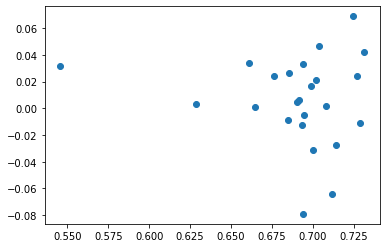

In [ ]:
amazon_data['Month'] = amazon_data['Date'].apply(lambda x: x.month)
amazon_data['Year'] = amazon_data['Date'].apply(lambda x: x.year)

# measures by how much the average price of a given month exceeds that on the first day of the month; 
# peformance is measured in percentage
amazonPerformance = amazon_data.groupby(['Year', 'Month'])['daily_avg'].agg(
    lambda x: (np.mean(x)-x.head(1))/x.head(1)).to_frame()
amazonPerformance
finalResult = pd.concat([dataNewAgg, amazonPerformance], axis=1)

plt.scatter(finalResult['sentimentScore'], finalResult['daily_avg'])

(0.06464299179319964, -0.040034247494827924)

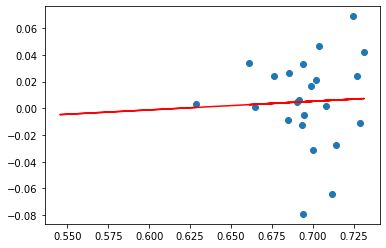

In [ ]:
finalResultNoOutlier = finalResult[finalResult['sentimentScore'] > 0.55]
m, b = np.polyfit(finalResultNoOutlier['sentimentScore'], finalResultNoOutlier['daily_avg'], 1)
x = finalResult['sentimentScore']
plt.scatter(finalResultNoOutlier['sentimentScore'], finalResultNoOutlier['daily_avg'])
plt.plot(x, m*x + b, color='red')
(m, b)

In [ ]:
# Correlation Coefficient Calculation:
x = finalResultNoOutlier['sentimentScore']
y = finalResultNoOutlier['daily_avg']

np.corrcoef(x, y)


    

array([[1.        , 0.04508854],
       [0.04508854, 1.        ]])

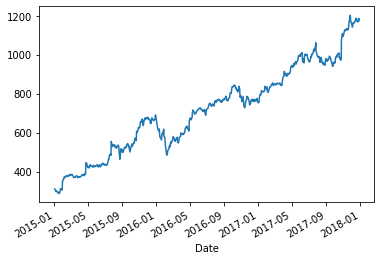

In [ ]:
avg_prices.plot()